# Fine-tuning DistilBERT on the IMDB Dataset using TensorFlow Transformers

This notebook is intended to be run in Google Colab.

Attention! To fine-tune the model within the resource limits of Google Colaboratory, the input sequence length has been reduced from 512 to 128.

This notebook demonstrates how to fine-tune the pre-trained DistilBERT model (`distilbert-base-uncased`) for the task of sentiment classification on the IMDB dataset using the Hugging Face Transformers library and TensorFlow.



## 1. Library Installation

In [ ]:
!pip install -q transformers datasets tensorflow
!pip install --upgrade datasets

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [3]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.5.5.0.38.14
astunparse                            1.6

## 2. Loading and Exploring the IMDB Dataset

In [ ]:
# Load IMDB dataset
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Sample subset for quicker development
train_df = train_df.sample(n=5000, random_state=42)
# test_df = test_df.sample(n=10, random_state=42)
test_df = test_df.sample(n=1000, random_state=42) # Increased test size for better evaluation

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Display sample data
print("\nSample review:")
sample = train_df.iloc[0]
print(f"Text: {sample['text'][:200]}...")
print(f"Sentiment: {'Positive' if sample['label'] == 1 else 'Negative'}")

In [4]:
train_df

,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1
...,...,...
8670,If you seen Rodney Dangerfield's previous movi...,0
11839,Anything that might have been potentially inte...,0
4013,That is quite an outdated movie which aims to ...,0
21147,"This is a comedy of morals, so occasionally a ...",1


In [5]:
# Train test spli
train_df, val_df = train_test_split(train_df, test_size=1000, random_state=42)

## 3. Load the Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

## 4. Tokenize and Prepare the Dataset

In [7]:
def tokenize_data(texts, labels):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=128, # The maximum sequence length has been reduced from 512 to 128 to save memory.
        return_tensors='tf'
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels)
    ))
    return dataset

train_dataset = tokenize_data(train_df['text'], train_df['label']).batch(32).shuffle(500)
val_dataset = tokenize_data(val_df['text'], val_df['label']).batch(32)
test_dataset = tokenize_data(test_df['text'], test_df['label']).batch(32)

In [8]:
train_dataset

<_ShuffleDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Get a Single Example (the First from the First Batch)
for batch in train_dataset.take(1):
    inputs, labels = batch
    input_ids = inputs["input_ids"][0].numpy()
    attention_mask = inputs["attention_mask"][0].numpy()
    label = labels[0].numpy()
    break

# Display input_ids (numerical tokens)
print("input_ids (encoded):")
print(input_ids)

# Display decoded text
print("\nDecoded text:")
print(tokenizer.decode(input_ids, skip_special_tokens=True))

# Display label
print("\nLabel:", "Positive" if label == 1 else "Negative")

input_ids (encoded):
[  101  1045  2074  2123  1005  1056  2156  2129  1037 16557  2063  1011
  2047 24484  2143  2856  2011  3958  1059  6038  5668  3211  1998  3794
  1996  3772 11725  1997  4080  8799  1998  1037 13997  2071  2022  2919
  1012  2009  2074 22132 17125  1996  2568  1010  2987  1005  1056  2009
  1029  1026  7987  1013  1028  1026  7987  1013  1028  2092  1010  2292
  1005  1055  2191  2053  6707  2055  2009  1012  1000 14163 12680  2666
  9326  2067  1000  2003  5262  1037  2919  2143  1012 14163 12680  2666
  2003  1037 13997  2040  2038  2042  2105  2005  2116  4693  1012  2005
  4436  2025  3929  4541  2127  1996  2203  1997  1996  2143  1010  2002
  2003  2741  2000  3011  2000  2393  1037  2309  2388  1998  2014  2365
  1012  1996  3566  1005  1055  3291  1006   102]

Decoded text:
i just don't see how a concorde - new horizons film directed by jim wynorski and featuring the acting talents of andrew stevens and a puppet could be bad. it just boggles the mind, doe

## 5. Load Model

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english", num_labels=2
)

## 6. Compile the Model

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

## 7. Training

In [ ]:
H = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
157/157 [==============================] - 99s 478ms/step - loss: 0.3950 - accuracy: 0.8384 - val_loss: 0.3189 - val_accuracy: 0.8570
Epoch 2/5
157/157 [==============================] - 73s 463ms/step - loss: 0.2651 - accuracy: 0.8942 - val_loss: 0.3341 - val_accuracy: 0.8520
Epoch 3/5
157/157 [==============================] - 73s 462ms/step - loss: 0.1614 - accuracy: 0.9408 - val_loss: 0.3483 - val_accuracy: 0.8630
Epoch 4/5
157/157 [==============================] - 72s 457ms/step - loss: 0.0743 - accuracy: 0.9764 - val_loss: 0.4842 - val_accuracy: 0.8500
Epoch 5/5
157/157 [==============================] - 72s 456ms/step - loss: 0.0399 - accuracy: 0.9872 - val_loss: 0.6135 - val_accuracy: 0.8510


## 8. Plot Evaluation Metrics During Training

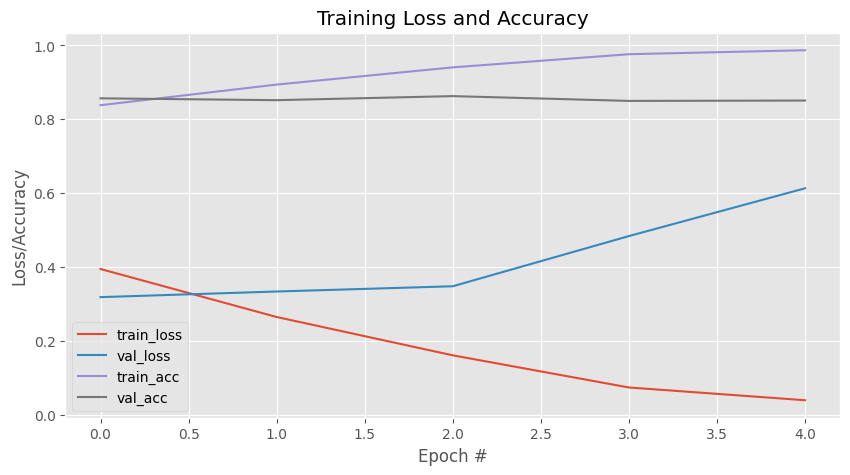

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 9. Test Evaluation

In [ ]:
# 1. Extract input_ids, attention_mask, and labels from test_dataset
all_input_ids = []
all_attention_mask = []
all_labels = []

for batch in test_dataset:
    all_input_ids.append(batch[0]['input_ids'])
    all_attention_mask.append(batch[0]['attention_mask'])
    all_labels.append(batch[1])

# 2. Merge All Batches into a Single Array
test_input_ids = tf.concat(all_input_ids, axis=0)
test_attention_mask = tf.concat(all_attention_mask, axis=0)
test_labels = tf.concat(all_labels, axis=0).numpy()

# 3. Make predictions
print("\n[INFO]: Evaluando modelo...")
preds = model.predict({"input_ids": test_input_ids, "attention_mask": test_attention_mask}, batch_size=32)
pred_labels = np.argmax(preds.logits, axis=1)

# 4. Display the Classification Report
print("\n[INFO]: Reporte de clasificación:")
print(classification_report(test_labels, pred_labels, target_names=["Negativo", "Positivo"]))


[INFO]: Evaluando modelo...
32/32 [==============================] - 6s 141ms/step

[INFO]: Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.89      0.81      0.85       511
    Positivo       0.82      0.90      0.85       489

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



## 10. Comparison with the Base Model (Without Fine-Tuning)

In [ ]:
original_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [22]:
# 1. Extract input_ids, attention_mask, and labels from test_dataset
all_input_ids = []
all_attention_mask = []
all_labels = []

for batch in test_dataset:
    all_input_ids.append(batch[0]['input_ids'])
    all_attention_mask.append(batch[0]['attention_mask'])
    all_labels.append(batch[1])

# 2. Merge All Batches into a Single Array
test_input_ids = tf.concat(all_input_ids, axis=0)
test_attention_mask = tf.concat(all_attention_mask, axis=0)
test_labels = tf.concat(all_labels, axis=0).numpy()

# 3. Make predictions
print("\n[INFO]: Evaluando modelo...")
preds = original_model.predict({"input_ids": test_input_ids, "attention_mask": test_attention_mask}, batch_size=32)
pred_labels = np.argmax(preds.logits, axis=1)

# 4. Display the Classification Report
print("\n[INFO]: Reporte de clasificación:")
print(classification_report(test_labels, pred_labels, target_names=["Negativo", "Positivo"]))


[INFO]: Evaluando modelo...
32/32 [==============================] - 8s 149ms/step

[INFO]: Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.80      0.87      0.83       511
    Positivo       0.85      0.77      0.81       489

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



## 12. Conclusion

The fine-tuned model slightly improves performance, achieving 85% accuracy on the test set compared to 82% with the base model.

However, there is significant overfitting in the fine-tuned model. It could be improved by:

* Increasing the size of the training dataset (only 5,000 samples were used for fine-tuning).

* Applying regularization techniques such as early stopping, additional weight decay, or data augmentation.